# Import libraries

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import scipy.stats
# from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from math import sqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':40})

from dateutil.parser import parse 
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
from pmdarima.arima.utils import ndiffs
import seaborn as sns

from stationarizer import simple_auto_stationarize

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
sns.set()



In [2]:
#import pyodbc library
import pyodbc

In [3]:
#check for drivers
for driver in pyodbc.drivers():
    print(driver)

SQL Server
Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)
SQL Server Native Client 11.0
SQL Server Native Client RDA 11.0
ODBC Driver 17 for SQL Server
Microsoft Access Driver (*.mdb, *.accdb)
Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)
Microsoft Access Text Driver (*.txt, *.csv)


In [4]:
#set connection
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-42IUD2D;'
                      'Database=Pharmacy_Price_Comparsion;'
                      'Trusted_Connection=yes;')

In [5]:
cursor = conn.cursor()

# Preparing price and date data of one product for timeseries analisys

In [6]:
#Time Series
benu_daily_ts = pd.read_sql_query('''SELECT product_name,price,date from dbo.benu_daily_raw_data''', conn)
benu_daily_ts

,product_name,price,date
0,ACC 100 mg granulátum gyermekeknek 30x3g,1549,25/07/2020
1,ACC 20 mg/ml belsőleges oldat 100ml,1549,25/07/2020
2,ACC 200 granulátum 30x3g,2499,25/07/2020
3,ACC Hot 600 mg por belsőleges oldathoz 10x,2599,25/07/2020
4,ACC Instant 600 mg belsőleges por 10x,2899,25/07/2020
...,...,...,...
17030,"Xyzal 0,5 mg/ml belsőleges oldat 200ml",2599,07/10/2020
17031,Xyzal 5 mg filmtabletta 10x,1249,07/10/2020
17032,Zilola 5 mg filmtabletta 28x,2299,07/10/2020
17033,Zyrtec 10 mg/ml belsőleges oldatos cseppek 20ml,1549,07/10/2020


In [7]:
#Fixing time period
benu_daily_ts.date=pd.to_datetime(benu_daily_ts.date,dayfirst=True)
benu_daily_ts['date'].unique()
benu_daily_ts=benu_daily_ts[benu_daily_ts['date']<'2020-09-11T00:00:00.000000000']
benu_daily_ts

,product_name,price,date
0,ACC 100 mg granulátum gyermekeknek 30x3g,1549,2020-07-25
1,ACC 20 mg/ml belsőleges oldat 100ml,1549,2020-07-25
2,ACC 200 granulátum 30x3g,2499,2020-07-25
3,ACC Hot 600 mg por belsőleges oldathoz 10x,2599,2020-07-25
4,ACC Instant 600 mg belsőleges por 10x,2899,2020-07-25
...,...,...,...
16435,"Xilomare Kid 0,5mg/ml oldatos orrspray 10ml",2099,2020-09-10
16436,"Xyzal 0,5 mg/ml belsőleges oldat 200ml",2599,2020-09-10
16437,Xyzal 5 mg filmtabletta 10x,1249,2020-09-10
16438,Zilola 5 mg filmtabletta 28x,2299,2020-09-10


In [8]:
#Remove these records
benu_daily_ts.drop(benu_daily_ts.loc[benu_daily_ts['price']=='üres'].index, inplace=True)
benu_daily_ts.drop(benu_daily_ts.loc[benu_daily_ts['price']=='Ã¼res'].index, inplace=True)

In [9]:
benu_daily_ts.isna().sum

<bound method DataFrame.sum of        product_name  price   date
0             False  False  False
1             False  False  False
2             False  False  False
3             False  False  False
4             False  False  False
...             ...    ...    ...
16435         False  False  False
16436         False  False  False
16437         False  False  False
16438         False  False  False
16439         False  False  False

[9588 rows x 3 columns]>

In [10]:
#Convert price to int
benu_daily_ts['price']=benu_daily_ts['price'].astype('float64')
type(benu_daily_ts['price'][0])

numpy.float64

In [11]:
type(benu_daily_ts['date'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [12]:
benu_daily_ts.iloc[0]

product_name    ACC 100 mg granulátum gyermekeknek 30x3g
price                                               1549
date                                 2020-07-25 00:00:00
Name: 0, dtype: object

In [13]:
product_names=benu_daily_ts['product_name'].unique()
product_names

array(['ACC 100 mg granulátum gyermekeknek 30x3g',
       'ACC 20 mg/ml belsőleges oldat 100ml', 'ACC 200 granulátum 30x3g',
       'ACC Hot 600 mg por belsőleges oldathoz 10x',
       'ACC Instant 600 mg belsőleges por 10x',
       'ACC long 600 mg pezsgőtabletta 10x',
       'Allegra 120 mg filmtabletta 10x',
       'Allegra Forte 180 mg filmtabletta 10x',
       'Allenasal 1mg/ml oldatos orrspray 10ml',
       'Allergodil oldatos orrspray 10ml',
       'Ambroxol-Teva 3 mg/ml szirup + szájfecskendő 100ml',
       'Ambroxol-TEVA 30 mg tabletta 30x',
       'Ambroxol-TEVA 75 mg retard kemény kapszula 20x',
       'Angised Mentol szopogató tabletta 24x',
       'Baby Luuf illóolajos kenőcs 30g', 'Bronchipret filmtabletta 20x',
       'Bronchipret szirup 50ml',
       'Bronchostop köhögés elleni belsőleges gumipasztilla 20x',
       'Bronchostop köhögés elleni belsőleges oldat 150ml',
       'Cetimax 10 mg filmtabletta 10x', 'Cezera 5 mg filmtabletta 30x',
       'Claritine 10 mg tablett

In [14]:
#Get the price values per day for a product
list_of_prices=[]
for i in range(len(product_names)):
    list_of_prices.append(benu_daily_ts.loc[benu_daily_ts["product_name"] == product_names[i]].drop_duplicates(subset='date')['price'].values)
list_of_prices


[array([1549., 1549., 1549., 1549., 1549., 1549., 1549., 1549., 1549.,
        1549., 1699., 1699., 1699., 1699., 1699., 1699., 1699., 1699.,
        1699., 1699., 1699., 1699., 1699., 1699., 1699., 1699., 1699.,
        1699., 1699., 1699., 1699., 1699., 1699., 1699., 1699., 1699.,
        1699., 1699., 1699., 1699., 1699., 1699., 1699., 1699., 1699.,
        1699., 1699., 1699.]),
 array([1549., 1549., 1549., 1549., 1549., 1549., 1549., 1549., 1549.,
        1549., 1699., 1699., 1699., 1699., 1699., 1699., 1699., 1699.,
        1699., 1699., 1699., 1699., 1699., 1699., 1699., 1699., 1699.,
        1699., 1699., 1699., 1699., 1699., 1699., 1699., 1699., 1699.,
        1699., 1699., 1699., 1699., 1699., 1699., 1699., 1699., 1699.,
        1699., 1699., 1699.]),
 array([2499., 2499., 2499., 2499., 2499., 2499., 2499., 2499., 2499.,
        2499., 2499., 2499., 2499., 2499., 2499., 2499., 2499., 2499.,
        2499., 2729., 2729., 2729., 2729., 2729., 2729., 2729., 2729.,
        2729., 

In [15]:
pd.Series((list_of_prices[0])).unique()

array([1549., 1699.])

In [16]:
number_of_price_change=[]
for i in range(len(list_of_prices)):
    number_of_price_change.append(len(pd.Series((list_of_prices[i])).unique()))
number_of_price_change    

[2,
 2,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 3,
 3,
 3,
 2,
 1,
 1,
 1,
 2,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 2,
 3,
 1,
 1,
 1,
 2,
 1,
 1,
 3,
 1,
 3,
 2,
 1]

In [17]:
type(number_of_price_change[0])

int

In [18]:
#Lets select the best candidate to test the solution. Looking for poruducts that had the most price changes during the examined period. This can be evaluated by checkin unique values of list_of_prices
benu_daily_ts_pc=[]
list_of_prices_ts_pc=[]
for i in range(len(number_of_price_change)):
    if number_of_price_change[i]>1:
        benu_daily_ts_pc.append(product_names[i])
        list_of_prices_ts_pc.append(list_of_prices[i])
len(benu_daily_ts_pc)
#benu_daily_ts_pc
#list_of_prices_ts_pc

35

In [19]:
benu_daily_ts

,product_name,price,date
0,ACC 100 mg granulátum gyermekeknek 30x3g,1549.0,2020-07-25
1,ACC 20 mg/ml belsőleges oldat 100ml,1549.0,2020-07-25
2,ACC 200 granulátum 30x3g,2499.0,2020-07-25
3,ACC Hot 600 mg por belsőleges oldathoz 10x,2599.0,2020-07-25
4,ACC Instant 600 mg belsőleges por 10x,2899.0,2020-07-25
...,...,...,...
16435,"Xilomare Kid 0,5mg/ml oldatos orrspray 10ml",2099.0,2020-09-10
16436,"Xyzal 0,5 mg/ml belsőleges oldat 200ml",2599.0,2020-09-10
16437,Xyzal 5 mg filmtabletta 10x,1249.0,2020-09-10
16438,Zilola 5 mg filmtabletta 28x,2299.0,2020-09-10


In [20]:
benu_daily_ts=benu_daily_ts.drop_duplicates(['date','product_name'], keep='last')
benu_daily_ts

,product_name,price,date
0,ACC 100 mg granulátum gyermekeknek 30x3g,1549.0,2020-07-25
1,ACC 20 mg/ml belsőleges oldat 100ml,1549.0,2020-07-25
2,ACC 200 granulátum 30x3g,2499.0,2020-07-25
3,ACC Hot 600 mg por belsőleges oldathoz 10x,2599.0,2020-07-25
4,ACC Instant 600 mg belsőleges por 10x,2899.0,2020-07-25
...,...,...,...
16435,"Xilomare Kid 0,5mg/ml oldatos orrspray 10ml",2099.0,2020-09-10
16436,"Xyzal 0,5 mg/ml belsőleges oldat 200ml",2599.0,2020-09-10
16437,Xyzal 5 mg filmtabletta 10x,1249.0,2020-09-10
16438,Zilola 5 mg filmtabletta 28x,2299.0,2020-09-10


In [21]:
#Filter to products that have had price change already
benu_daily_ts = benu_daily_ts[benu_daily_ts['product_name'].isin(benu_daily_ts_pc)]
benu_daily_ts

,product_name,price,date
0,ACC 100 mg granulátum gyermekeknek 30x3g,1549.0,2020-07-25
1,ACC 20 mg/ml belsőleges oldat 100ml,1549.0,2020-07-25
2,ACC 200 granulátum 30x3g,2499.0,2020-07-25
9,Allergodil oldatos orrspray 10ml,2249.0,2020-07-25
10,Ambroxol-Teva 3 mg/ml szirup + szájfecskendő 1...,2159.0,2020-07-25
...,...,...,...
16430,Teva-Ambrobene 15 mg/5 ml szirup 100ml,1049.0,2020-09-10
16432,Vibrocil oldatos orrcsepp 15ml,1499.0,2020-09-10
16433,Wick TriActin citrom ízű por belsőleges oldath...,2529.0,2020-09-10
16434,Wick Vaporub kenőcs 50g,2529.0,2020-09-10


# Test entire dataset with Dickey-Fuller and KPSS

In [22]:
#Reminder how the prepared dataset looks like
benu_daily_ts

,product_name,price,date
0,ACC 100 mg granulátum gyermekeknek 30x3g,1549.0,2020-07-25
1,ACC 20 mg/ml belsőleges oldat 100ml,1549.0,2020-07-25
2,ACC 200 granulátum 30x3g,2499.0,2020-07-25
9,Allergodil oldatos orrspray 10ml,2249.0,2020-07-25
10,Ambroxol-Teva 3 mg/ml szirup + szájfecskendő 1...,2159.0,2020-07-25
...,...,...,...
16430,Teva-Ambrobene 15 mg/5 ml szirup 100ml,1049.0,2020-09-10
16432,Vibrocil oldatos orrcsepp 15ml,1499.0,2020-09-10
16433,Wick TriActin citrom ízű por belsőleges oldath...,2529.0,2020-09-10
16434,Wick Vaporub kenőcs 50g,2529.0,2020-09-10


In [23]:
# benu_daily_ts=benu_daily_ts.drop_duplicates(['date','product_name'], keep='last')
# benu_daily_ts

In [24]:
#Set date column as index
benu_daily_ts['date']
benu_daily_ts.set_index('date', inplace=True)
benu_daily_ts
# del benu_daily_ts['product_name']

,product_name,price
date,,
2020-07-25,ACC 100 mg granulátum gyermekeknek 30x3g,1549.0
2020-07-25,ACC 20 mg/ml belsőleges oldat 100ml,1549.0
2020-07-25,ACC 200 granulátum 30x3g,2499.0
2020-07-25,Allergodil oldatos orrspray 10ml,2249.0
2020-07-25,Ambroxol-Teva 3 mg/ml szirup + szájfecskendő 1...,2159.0
...,...,...
2020-09-10,Teva-Ambrobene 15 mg/5 ml szirup 100ml,1049.0
2020-09-10,Vibrocil oldatos orrcsepp 15ml,1499.0
2020-09-10,Wick TriActin citrom ízű por belsőleges oldath...,2529.0


In [25]:
# #Set freq
# benu_daily_ts=benu_daily_ts.asfreq('d')
# benu_daily_ts

In [26]:
# #Splitting the data to training and test sets
# size=int(len(benu_daily_first_product)*0.8)
# benu_daily_first_product_train=benu_daily_first_product.iloc[:size]
# benu_daily_first_product_test=benu_daily_first_product.iloc[size:]

In [27]:
# benu_daily_ts[benu_daily_ts['product_name']==benu_daily_ts_pc[0]]

In [28]:
#Go through the benu_daily_ts and run Dickey-Fuller and KPSS test then add data in dataframe 

#################################################################
#Evaluation happened based on p value, ADF and test statistics!!!
#################################################################

benu_daily_ts_stationarity=pd.DataFrame(columns=['product_names', 'Dickey_Fuller_ADF','Dickey_Fuller_p', 'Dickey_Fuller_critical_1', 'Dickey_Fuller_critical_5', 'Dickey_Fuller_critical_10', 'Dickey_Fuller_result','KPSS_test_stats','KPSS_p','KPSS_lags_used', 'KPSS_critical_1', 'KPSS_critical_5', 'KPSS_critical_10', 'KPSS_result', 'Non-stationary'])
benu_daily_ts_stationarity['product_names']=benu_daily_ts_pc

for i in range(len(benu_daily_ts_pc)):
    product_filter=(benu_daily_ts[benu_daily_ts['product_name']==benu_daily_ts_pc[i]])
    product_filter.price=product_filter.price.astype(int)
    product_filter=product_filter.asfreq('d')     
    #print(product_filter)
    #del product_filter['product_name']
    size=int(len(product_filter)*0.8)
    product_filter_train=product_filter.iloc[:size]
    product_filter_test=product_filter.iloc[size:]
    #Run Dickey-Fuller Test
    result = adfuller(product_filter.price)
    benu_daily_ts_stationarity['Dickey_Fuller_ADF'][i]=result[0]
    benu_daily_ts_stationarity['Dickey_Fuller_p'][i]=result[1]  
    critical_values=[]
    for key, value in result[4].items():
        critical_values.append(value)
#     print(critical_values[0])
#     print(critical_values[1])
#     print(critical_values[2])
    benu_daily_ts_stationarity['Dickey_Fuller_critical_1'][i]=critical_values[0]
    benu_daily_ts_stationarity['Dickey_Fuller_critical_5'][i]=critical_values[1]
    benu_daily_ts_stationarity['Dickey_Fuller_critical_10'][i]=critical_values[2]
    
#     #Based on Dickey-Fuller test evaluate if data is stationary or non-stationary
#     if benu_daily_ts_stationarity['Dickey_Fuller_ADF'][i]> benu_daily_ts_stationarity['Dickey_Fuller_critical_10'][i] and benu_daily_ts_stationarity['Dickey_Fuller_p'][i]>0.05:
#         benu_daily_ts_stationarity['Dickey_Fuller_result'][i]='non-stationary'
#     else:benu_daily_ts_stationarity['Dickey_Fuller_result'][i]='stationary'

    #Based on Dickey-Fuller test evaluate if data is stationary or non-stationary
    if benu_daily_ts_stationarity['Dickey_Fuller_ADF'][i]> benu_daily_ts_stationarity['Dickey_Fuller_critical_1'][i] and benu_daily_ts_stationarity['Dickey_Fuller_p'][i]>0.05:
        benu_daily_ts_stationarity['Dickey_Fuller_result'][i]='non-stationary'
    elif benu_daily_ts_stationarity['Dickey_Fuller_ADF'][i]< benu_daily_ts_stationarity['Dickey_Fuller_critical_10'][i] and benu_daily_ts_stationarity['Dickey_Fuller_p'][i]<0.05:
        benu_daily_ts_stationarity['Dickey_Fuller_result'][i]='stationary'
    else: benu_daily_ts_stationarity['Dickey_Fuller_result'][i]='NaN or tbd'
    
     #Run KPSS test
    def kpss_test_test_stats(timeseries):
        kpsstest = kpss(timeseries, regression='c')
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        return kpss_output[0]
        
    def kpss_test_p(timeseries):
        kpsstest = kpss(timeseries, regression='c')
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        return kpss_output[1]
    
    def kpss_test_lags_used(timeseries):
        kpsstest = kpss(timeseries, regression='c')
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        return kpss_output[2]
    
    def kpss_test_critcial1(timeseries):
        kpsstest = kpss(timeseries, regression='c')
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        return kpss_output[3]
        
    def kpss_test_critcial2(timeseries):
        kpsstest = kpss(timeseries, regression='c')
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        return kpss_output[4]
        
    def kpss_test_critcial3(timeseries):
        kpsstest = kpss(timeseries, regression='c')
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        return kpss_output[5]

    benu_daily_ts_stationarity['KPSS_test_stats'][i]=kpss_test_test_stats(product_filter.price)
    benu_daily_ts_stationarity['KPSS_p'][i]=kpss_test_p(product_filter.price)
    benu_daily_ts_stationarity['KPSS_lags_used'][i]=kpss_test_lags_used(product_filter.price)
    benu_daily_ts_stationarity['KPSS_critical_1'][i]=kpss_test_critcial1(product_filter.price)
    benu_daily_ts_stationarity['KPSS_critical_5'][i]=kpss_test_critcial2(product_filter.price)
    benu_daily_ts_stationarity['KPSS_critical_10'][i]=kpss_test_critcial3(product_filter.price)
    
    #Based on KPSS test evaluate if data is stationary or non-stationary
    if benu_daily_ts_stationarity['KPSS_test_stats'][i]>benu_daily_ts_stationarity['KPSS_critical_1'][i] and benu_daily_ts_stationarity['KPSS_p'][i]>0.05:
        benu_daily_ts_stationarity['KPSS_result'][i]='non-stationary'
    elif benu_daily_ts_stationarity['KPSS_test_stats'][i]<benu_daily_ts_stationarity['KPSS_critical_10'][i] and benu_daily_ts_stationarity['KPSS_p'][i]<0.05:
        benu_daily_ts_stationarity['KPSS_result'][i]='stationary'
    else: benu_daily_ts_stationarity['KPSS_result'][i]='NaN or tbd'  
      
    
    #Sum up the 2 tests    
    if benu_daily_ts_stationarity['KPSS_result'][i]=='non-stationary' and benu_daily_ts_stationarity['Dickey_Fuller_result'][i]=='non-stationary':
        benu_daily_ts_stationarity['Non-stationary'][i]='non-stationary'
    else:benu_daily_ts_stationarity['Non-stationary'][i]='tbd'


In [29]:
benu_daily_ts_stationarity

,product_names,Dickey_Fuller_ADF,Dickey_Fuller_p,Dickey_Fuller_critical_1,Dickey_Fuller_critical_5,Dickey_Fuller_critical_10,Dickey_Fuller_result,KPSS_test_stats,KPSS_p,KPSS_lags_used,KPSS_critical_1,KPSS_critical_5,KPSS_critical_10,KPSS_result,Non-stationary
0,ACC 100 mg granulátum gyermekeknek 30x3g,-1.31101,0.62412,-3.73771,-2.99222,-2.63575,non-stationary,0.344612,0.1,9,0.347,0.463,0.574,NaN or tbd,tbd
1,ACC 20 mg/ml belsőleges oldat 100ml,-1.31101,0.62412,-3.73771,-2.99222,-2.63575,non-stationary,0.344612,0.1,9,0.347,0.463,0.574,NaN or tbd,tbd
2,ACC 200 granulátum 30x3g,-0.504608,0.891114,-3.73771,-2.99222,-2.63575,non-stationary,0.345674,0.1,9,0.347,0.463,0.574,NaN or tbd,tbd
3,Allergodil oldatos orrspray 10ml,-1.52022,0.523489,-3.66143,-2.96053,-2.61932,non-stationary,0.171497,0.1,10,0.347,0.463,0.574,NaN or tbd,tbd
4,Ambroxol-Teva 3 mg/ml szirup + szájfecskendő 1...,NaN,NaN,-3.66143,-2.96053,-2.61932,NaN or tbd,NaN,NaN,10,0.347,0.463,0.574,NaN or tbd,tbd
5,Daedalon 50 mg tabletta 10x,-1.56038,0.50346,-3.75293,-2.9985,-2.63897,non-stationary,0.343356,0.1,9,0.347,0.463,0.574,NaN or tbd,tbd
6,Dorithricin szopogató tabletta erdei gyümölcs ...,-0.789719,0.822123,-3.66143,-2.96053,-2.61932,non-stationary,0.36477,0.0923406,10,0.347,0.463,0.574,non-stationary,non-stationary
7,Grippostad C kemény kapszula 20x,NaN,NaN,-3.66143,-2.96053,-2.61932,NaN or tbd,NaN,NaN,10,0.347,0.463,0.574,NaN or tbd,tbd
8,Halixol 30 mg tabletta 20x,-1.47743,0.544646,-3.66143,-2.96053,-2.61932,non-stationary,0.357111,0.0956417,10,0.347,0.463,0.574,non-stationary,non-stationary
9,Inaller 5 mg filmtabletta 30x,-1.93441,0.316051,-3.66143,-2.96053,-2.61932,non-stationary,0.35187,0.0979008,10,0.347,0.463,0.574,non-stationary,non-stationary


In [30]:
#Check how many non stationary
len(benu_daily_ts_stationarity[benu_daily_ts_stationarity['Non-stationary']=='non-stationary'])

14

In [31]:
#Check how many stationary
len(benu_daily_ts_stationarity[benu_daily_ts_stationarity['Non-stationary']=='stationary'])

0

In [32]:
#Check how many stationary based on only the Dickey-Fuller test
benu_daily_ts_stationarity[benu_daily_ts_stationarity['Dickey_Fuller_result']=='stationary']

,product_names,Dickey_Fuller_ADF,Dickey_Fuller_p,Dickey_Fuller_critical_1,Dickey_Fuller_critical_5,Dickey_Fuller_critical_10,Dickey_Fuller_result,KPSS_test_stats,KPSS_p,KPSS_lags_used,KPSS_critical_1,KPSS_critical_5,KPSS_critical_10,KPSS_result,Non-stationary
30,Wick Vaporub kenőcs 50g,-4.41954,0.000274072,-3.5925,-2.93155,-2.60407,stationary,0.354193,0.0968995,10,0.347,0.463,0.574,non-stationary,tbd
32,Dassergo 5 mg filmtabletta 30x,-4.70679,8.17166e-05,-3.71121,-2.98125,-2.63009,stationary,0.345938,0.1,9,0.347,0.463,0.574,NaN or tbd,tbd
34,Teva-Ambrobene 15 mg/5 ml szirup 100ml,-3.47325,0.00870116,-3.59664,-2.9333,-2.60499,stationary,0.351641,0.0979995,10,0.347,0.463,0.574,non-stationary,tbd


In [33]:
#Check how many stationary based on only the KPSS test
benu_daily_ts_stationarity[benu_daily_ts_stationarity['KPSS_result']=='stationary']

,product_names,Dickey_Fuller_ADF,Dickey_Fuller_p,Dickey_Fuller_critical_1,Dickey_Fuller_critical_5,Dickey_Fuller_critical_10,Dickey_Fuller_result,KPSS_test_stats,KPSS_p,KPSS_lags_used,KPSS_critical_1,KPSS_critical_5,KPSS_critical_10,KPSS_result,Non-stationary
15,"Otrivin Rapid 1 mg/ml oldatos orrcsepp (0,1%) ...",-1.63309,0.465875,-3.57785,-2.92534,-2.60077,non-stationary,0.487486,0.0444852,10,0.347,0.463,0.574,stationary,tbd
19,Robitussin Expectorans szirup 100ml,-1.12733,0.704052,-3.57785,-2.92534,-2.60077,non-stationary,0.512544,0.0388416,10,0.347,0.463,0.574,stationary,tbd
20,Robitussin Junior szirup 100ml,-1.12733,0.704052,-3.57785,-2.92534,-2.60077,non-stationary,0.512544,0.0388416,10,0.347,0.463,0.574,stationary,tbd
28,Vibrocil oldatos orrcsepp 15ml,-1.12733,0.704052,-3.57785,-2.92534,-2.60077,non-stationary,0.512544,0.0388416,10,0.347,0.463,0.574,stationary,tbd


# Loop through & analyze which product's data is stationary 

In [34]:
#Go through the benu_daily_ts and run Dickey-Fuller and KPSS test then add data in dataframe 

#############################################
#Evaluation happened based on p value only!!!
#############################################

benu_daily_ts_stationarity=pd.DataFrame(columns=['product_names', 'Dickey_Fuller_ADF','Dickey_Fuller_p', 'Dickey_Fuller_critical_1', 'Dickey_Fuller_critical_5', 'Dickey_Fuller_critical_10', 'Dickey_Fuller_result','KPSS_test_stats','KPSS_p','KPSS_lags_used', 'KPSS_critical_1', 'KPSS_critical_5', 'KPSS_critical_10', 'KPSS_result', 'is_stationary'])
benu_daily_ts_stationarity['product_names']=benu_daily_ts_pc

for i in range(len(benu_daily_ts_pc)):
    product_filter=(benu_daily_ts[benu_daily_ts['product_name']==benu_daily_ts_pc[i]])
    product_filter.price=product_filter.price.astype(int)
    product_filter=product_filter.asfreq('d')     
    #print(product_filter)
    #del product_filter['product_name']
    size=int(len(product_filter)*0.8)
    product_filter_train=product_filter.iloc[:size]
    product_filter_test=product_filter.iloc[size:]
    #Run Dickey-Fuller Test
    result = adfuller(product_filter.price)
    benu_daily_ts_stationarity['Dickey_Fuller_ADF'][i]=result[0]
    benu_daily_ts_stationarity['Dickey_Fuller_p'][i]=result[1]  
    critical_values=[]
    for key, value in result[4].items():
        critical_values.append(value)
#     print(critical_values[0])
#     print(critical_values[1])
#     print(critical_values[2])
    benu_daily_ts_stationarity['Dickey_Fuller_critical_1'][i]=critical_values[0]
    benu_daily_ts_stationarity['Dickey_Fuller_critical_5'][i]=critical_values[1]
    benu_daily_ts_stationarity['Dickey_Fuller_critical_10'][i]=critical_values[2]
    
#     #Based on Dickey-Fuller test evaluate if data is stationary or non-stationary
#     if benu_daily_ts_stationarity['Dickey_Fuller_ADF'][i]> benu_daily_ts_stationarity['Dickey_Fuller_critical_10'][i] and benu_daily_ts_stationarity['Dickey_Fuller_p'][i]>0.05:
#         benu_daily_ts_stationarity['Dickey_Fuller_result'][i]='non-stationary'
#     else:benu_daily_ts_stationarity['Dickey_Fuller_result'][i]='stationary'

    #Based on Dickey-Fuller test evaluate if data is stationary or non-stationary
    if benu_daily_ts_stationarity['Dickey_Fuller_p'][i]>0.05:
        benu_daily_ts_stationarity['Dickey_Fuller_result'][i]='non-stationary'
    elif benu_daily_ts_stationarity['Dickey_Fuller_p'][i]<0.05:
        benu_daily_ts_stationarity['Dickey_Fuller_result'][i]='stationary'
    else: benu_daily_ts_stationarity['Dickey_Fuller_result'][i]='NaN or tbd'
    
     #Run KPSS test
    def kpss_test_test_stats(timeseries):
        kpsstest = kpss(timeseries, regression='c')
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        return kpss_output[0]
        
    def kpss_test_p(timeseries):
        kpsstest = kpss(timeseries, regression='c')
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        return kpss_output[1]
    
    def kpss_test_lags_used(timeseries):
        kpsstest = kpss(timeseries, regression='c')
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        return kpss_output[2]
    
    def kpss_test_critcial1(timeseries):
        kpsstest = kpss(timeseries, regression='c')
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        return kpss_output[3]
        
    def kpss_test_critcial2(timeseries):
        kpsstest = kpss(timeseries, regression='c')
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        return kpss_output[4]
        
    def kpss_test_critcial3(timeseries):
        kpsstest = kpss(timeseries, regression='c')
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        return kpss_output[5]

    benu_daily_ts_stationarity['KPSS_test_stats'][i]=kpss_test_test_stats(product_filter.price)
    benu_daily_ts_stationarity['KPSS_p'][i]=kpss_test_p(product_filter.price)
    benu_daily_ts_stationarity['KPSS_lags_used'][i]=kpss_test_lags_used(product_filter.price)
    benu_daily_ts_stationarity['KPSS_critical_1'][i]=kpss_test_critcial1(product_filter.price)
    benu_daily_ts_stationarity['KPSS_critical_5'][i]=kpss_test_critcial2(product_filter.price)
    benu_daily_ts_stationarity['KPSS_critical_10'][i]=kpss_test_critcial3(product_filter.price)
    
    #Based on KPSS test evaluate if data is stationary or non-stationary
    if benu_daily_ts_stationarity['KPSS_p'][i]>0.05:
        benu_daily_ts_stationarity['KPSS_result'][i]='non-stationary'
    elif benu_daily_ts_stationarity['KPSS_p'][i]<0.05:
        benu_daily_ts_stationarity['KPSS_result'][i]='stationary'
    else: benu_daily_ts_stationarity['KPSS_result'][i]='NaN or tbd'  
      
    
    #Sum up the 2 tests    
    if benu_daily_ts_stationarity['KPSS_result'][i]=='non-stationary' and benu_daily_ts_stationarity['Dickey_Fuller_result'][i]=='non-stationary':
        benu_daily_ts_stationarity['is_stationary'][i]='non-stationary'
    else:benu_daily_ts_stationarity['is_stationary'][i]='tbd'


In [35]:
benu_daily_ts_stationarity

,product_names,Dickey_Fuller_ADF,Dickey_Fuller_p,Dickey_Fuller_critical_1,Dickey_Fuller_critical_5,Dickey_Fuller_critical_10,Dickey_Fuller_result,KPSS_test_stats,KPSS_p,KPSS_lags_used,KPSS_critical_1,KPSS_critical_5,KPSS_critical_10,KPSS_result,is_stationary
0,ACC 100 mg granulátum gyermekeknek 30x3g,-1.31101,0.62412,-3.73771,-2.99222,-2.63575,non-stationary,0.344612,0.1,9,0.347,0.463,0.574,non-stationary,non-stationary
1,ACC 20 mg/ml belsőleges oldat 100ml,-1.31101,0.62412,-3.73771,-2.99222,-2.63575,non-stationary,0.344612,0.1,9,0.347,0.463,0.574,non-stationary,non-stationary
2,ACC 200 granulátum 30x3g,-0.504608,0.891114,-3.73771,-2.99222,-2.63575,non-stationary,0.345674,0.1,9,0.347,0.463,0.574,non-stationary,non-stationary
3,Allergodil oldatos orrspray 10ml,-1.52022,0.523489,-3.66143,-2.96053,-2.61932,non-stationary,0.171497,0.1,10,0.347,0.463,0.574,non-stationary,non-stationary
4,Ambroxol-Teva 3 mg/ml szirup + szájfecskendő 1...,NaN,NaN,-3.66143,-2.96053,-2.61932,NaN or tbd,NaN,NaN,10,0.347,0.463,0.574,NaN or tbd,tbd
5,Daedalon 50 mg tabletta 10x,-1.56038,0.50346,-3.75293,-2.9985,-2.63897,non-stationary,0.343356,0.1,9,0.347,0.463,0.574,non-stationary,non-stationary
6,Dorithricin szopogató tabletta erdei gyümölcs ...,-0.789719,0.822123,-3.66143,-2.96053,-2.61932,non-stationary,0.36477,0.0923406,10,0.347,0.463,0.574,non-stationary,non-stationary
7,Grippostad C kemény kapszula 20x,NaN,NaN,-3.66143,-2.96053,-2.61932,NaN or tbd,NaN,NaN,10,0.347,0.463,0.574,NaN or tbd,tbd
8,Halixol 30 mg tabletta 20x,-1.47743,0.544646,-3.66143,-2.96053,-2.61932,non-stationary,0.357111,0.0956417,10,0.347,0.463,0.574,non-stationary,non-stationary
9,Inaller 5 mg filmtabletta 30x,-1.93441,0.316051,-3.66143,-2.96053,-2.61932,non-stationary,0.35187,0.0979008,10,0.347,0.463,0.574,non-stationary,non-stationary


In [36]:
#Check how many non stationary
len(benu_daily_ts_stationarity[benu_daily_ts_stationarity['is_stationary']=='non-stationary'])

24

In [37]:
#Check how many stationary
len(benu_daily_ts_stationarity[benu_daily_ts_stationarity['is_stationary']=='stationary'])

0

In [38]:
#Check how many stationary based on only the Dickey-Fuller test
len(benu_daily_ts_stationarity[benu_daily_ts_stationarity['Dickey_Fuller_result']=='stationary'])

3

In [39]:
benu_daily_ts_stationarity[benu_daily_ts_stationarity['Dickey_Fuller_result']=='stationary']

,product_names,Dickey_Fuller_ADF,Dickey_Fuller_p,Dickey_Fuller_critical_1,Dickey_Fuller_critical_5,Dickey_Fuller_critical_10,Dickey_Fuller_result,KPSS_test_stats,KPSS_p,KPSS_lags_used,KPSS_critical_1,KPSS_critical_5,KPSS_critical_10,KPSS_result,is_stationary
30,Wick Vaporub kenőcs 50g,-4.41954,0.000274072,-3.5925,-2.93155,-2.60407,stationary,0.354193,0.0968995,10,0.347,0.463,0.574,non-stationary,tbd
32,Dassergo 5 mg filmtabletta 30x,-4.70679,8.17166e-05,-3.71121,-2.98125,-2.63009,stationary,0.345938,0.1,9,0.347,0.463,0.574,non-stationary,tbd
34,Teva-Ambrobene 15 mg/5 ml szirup 100ml,-3.47325,0.00870116,-3.59664,-2.9333,-2.60499,stationary,0.351641,0.0979995,10,0.347,0.463,0.574,non-stationary,tbd


In [40]:
#Check how many stationary based on only the KPSS test
benu_daily_ts_stationarity[benu_daily_ts_stationarity['KPSS_result']=='stationary']

,product_names,Dickey_Fuller_ADF,Dickey_Fuller_p,Dickey_Fuller_critical_1,Dickey_Fuller_critical_5,Dickey_Fuller_critical_10,Dickey_Fuller_result,KPSS_test_stats,KPSS_p,KPSS_lags_used,KPSS_critical_1,KPSS_critical_5,KPSS_critical_10,KPSS_result,is_stationary
15,"Otrivin Rapid 1 mg/ml oldatos orrcsepp (0,1%) ...",-1.63309,0.465875,-3.57785,-2.92534,-2.60077,non-stationary,0.487486,0.0444852,10,0.347,0.463,0.574,stationary,tbd
19,Robitussin Expectorans szirup 100ml,-1.12733,0.704052,-3.57785,-2.92534,-2.60077,non-stationary,0.512544,0.0388416,10,0.347,0.463,0.574,stationary,tbd
20,Robitussin Junior szirup 100ml,-1.12733,0.704052,-3.57785,-2.92534,-2.60077,non-stationary,0.512544,0.0388416,10,0.347,0.463,0.574,stationary,tbd
28,Vibrocil oldatos orrcsepp 15ml,-1.12733,0.704052,-3.57785,-2.92534,-2.60077,non-stationary,0.512544,0.0388416,10,0.347,0.463,0.574,stationary,tbd


# Loop through the data where stationarity can be defined and spcify type of stationarity

In [41]:
# Go through the dataframe and modify 'is_stationary' in case:
# Case 1: Both tests conclude that the series is not stationary - The series is not stationary
# Case 2: Both tests conclude that the series is stationary - The series is stationary
# Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. 
#     Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
# Case 4: KPSS indicates non-stationarity and ADF indicates stationarity.
#     The series is difference stationary. Differencing is to be used to make series stationary. 
#     The differenced series is checked for stationarity.
    
for i in range(len(benu_daily_ts_stationarity)):
    if benu_daily_ts_stationarity['is_stationary'][i]=='tbd':
        if benu_daily_ts_stationarity['Dickey_Fuller_result'].iloc[i]=='stationary' and benu_daily_ts_stationarity['KPSS_result'].iloc[i]=='non-stationary':
            benu_daily_ts_stationarity['is_stationary'].iloc[i]='difference_stationary'    
        elif benu_daily_ts_stationarity['Dickey_Fuller_result'].iloc[i]=='non-stationary' and benu_daily_ts_stationarity['KPSS_result'].iloc[i]=='stationary': 
            benu_daily_ts_stationarity['is_stationary'].iloc[i]='trend_stationary'    

#benu_daily_ts_stationarity
benu_daily_ts_stationarity_defined=benu_daily_ts_stationarity[benu_daily_ts_stationarity['is_stationary']!='tbd']
benu_daily_ts_stationarity_defined

,product_names,Dickey_Fuller_ADF,Dickey_Fuller_p,Dickey_Fuller_critical_1,Dickey_Fuller_critical_5,Dickey_Fuller_critical_10,Dickey_Fuller_result,KPSS_test_stats,KPSS_p,KPSS_lags_used,KPSS_critical_1,KPSS_critical_5,KPSS_critical_10,KPSS_result,is_stationary
0,ACC 100 mg granulátum gyermekeknek 30x3g,-1.31101,0.62412,-3.73771,-2.99222,-2.63575,non-stationary,0.344612,0.1,9,0.347,0.463,0.574,non-stationary,non-stationary
1,ACC 20 mg/ml belsőleges oldat 100ml,-1.31101,0.62412,-3.73771,-2.99222,-2.63575,non-stationary,0.344612,0.1,9,0.347,0.463,0.574,non-stationary,non-stationary
2,ACC 200 granulátum 30x3g,-0.504608,0.891114,-3.73771,-2.99222,-2.63575,non-stationary,0.345674,0.1,9,0.347,0.463,0.574,non-stationary,non-stationary
3,Allergodil oldatos orrspray 10ml,-1.52022,0.523489,-3.66143,-2.96053,-2.61932,non-stationary,0.171497,0.1,10,0.347,0.463,0.574,non-stationary,non-stationary
5,Daedalon 50 mg tabletta 10x,-1.56038,0.50346,-3.75293,-2.9985,-2.63897,non-stationary,0.343356,0.1,9,0.347,0.463,0.574,non-stationary,non-stationary
6,Dorithricin szopogató tabletta erdei gyümölcs ...,-0.789719,0.822123,-3.66143,-2.96053,-2.61932,non-stationary,0.36477,0.0923406,10,0.347,0.463,0.574,non-stationary,non-stationary
8,Halixol 30 mg tabletta 20x,-1.47743,0.544646,-3.66143,-2.96053,-2.61932,non-stationary,0.357111,0.0956417,10,0.347,0.463,0.574,non-stationary,non-stationary
9,Inaller 5 mg filmtabletta 30x,-1.93441,0.316051,-3.66143,-2.96053,-2.61932,non-stationary,0.35187,0.0979008,10,0.347,0.463,0.574,non-stationary,non-stationary
12,"Nasivin Kids 0,25 mg/ml oldatos orrcsepp 10ml",-0.341704,0.919387,-3.57785,-2.92534,-2.60077,non-stationary,0.363765,0.0927738,10,0.347,0.463,0.574,non-stationary,non-stationary
13,Nasopax orrspray felnőtteknek 10ml,-0.482589,0.89537,-3.57785,-2.92534,-2.60077,non-stationary,0.389688,0.0815998,10,0.347,0.463,0.574,non-stationary,non-stationary


In [42]:
# create excel writer object
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y")
writer = pd.ExcelWriter(dt_string+'stationary_defined'+'.xlsx')
# write dataframe to excel
benu_daily_ts_stationarity_defined.to_excel(writer)
# save the excel
writer.save()
print('DataFrame is written successfully to Excel File.')

DataFrame is written successfully to Excel File.


In [43]:
#Filter to stationary data based on Dickey-Fuller test
benu_daily_ts_not_non_stationary=np.array(benu_daily_ts_stationarity_defined[benu_daily_ts_stationarity_defined['Dickey_Fuller_result']!='non-stationary']['product_names'])
benu_daily_ts_not_non_stationary

array(['Wick Vaporub kenőcs 50g', 'Dassergo 5 mg filmtabletta 30x',
       'Teva-Ambrobene 15 mg/5 ml szirup 100ml'], dtype=object)

In [44]:
#Filter to stationary data based on Dickey-Fuller test
benu_daily_ts_not_non_stationary_DF=benu_daily_ts_stationarity_defined[benu_daily_ts_stationarity_defined['Dickey_Fuller_result']!='non-stationary']
benu_daily_ts_not_non_stationary_DF

,product_names,Dickey_Fuller_ADF,Dickey_Fuller_p,Dickey_Fuller_critical_1,Dickey_Fuller_critical_5,Dickey_Fuller_critical_10,Dickey_Fuller_result,KPSS_test_stats,KPSS_p,KPSS_lags_used,KPSS_critical_1,KPSS_critical_5,KPSS_critical_10,KPSS_result,is_stationary
30,Wick Vaporub kenőcs 50g,-4.41954,0.000274072,-3.5925,-2.93155,-2.60407,stationary,0.354193,0.0968995,10,0.347,0.463,0.574,non-stationary,difference_stationary
32,Dassergo 5 mg filmtabletta 30x,-4.70679,8.17166e-05,-3.71121,-2.98125,-2.63009,stationary,0.345938,0.1,9,0.347,0.463,0.574,non-stationary,difference_stationary
34,Teva-Ambrobene 15 mg/5 ml szirup 100ml,-3.47325,0.00870116,-3.59664,-2.9333,-2.60499,stationary,0.351641,0.0979995,10,0.347,0.463,0.574,non-stationary,difference_stationary


In [45]:
# create excel writer object
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y")
writer = pd.ExcelWriter(dt_string+'benu_daily_ts_not_non_stationary_DF'+'.xlsx')
# write dataframe to excel
benu_daily_ts_not_non_stationary_DF.to_excel(writer)
# save the excel
writer.save()
print('DataFrame is written successfully to Excel File.')

DataFrame is written successfully to Excel File.


In [46]:
#Filter to stationary data based on Dickey-Fuller test
benu_daily_ts_not_non_stationary_v2=np.array(benu_daily_ts_stationarity_defined[benu_daily_ts_stationarity_defined['is_stationary']!='non-stationary']['product_names'])
benu_daily_ts_not_non_stationary_v2

array(['Otrivin Rapid 1 mg/ml oldatos orrcsepp (0,1%) 10ml',
       'Robitussin Expectorans szirup 100ml',
       'Robitussin Junior szirup 100ml', 'Vibrocil oldatos orrcsepp 15ml',
       'Wick Vaporub kenőcs 50g', 'Dassergo 5 mg filmtabletta 30x',
       'Teva-Ambrobene 15 mg/5 ml szirup 100ml'], dtype=object)

In [47]:
#Filter to stationary data based on Dickey-Fuller test
benu_daily_ts_not_non_stationary_all=benu_daily_ts_stationarity_defined[benu_daily_ts_stationarity_defined['is_stationary']!='non-stationary']
benu_daily_ts_not_non_stationary_all

,product_names,Dickey_Fuller_ADF,Dickey_Fuller_p,Dickey_Fuller_critical_1,Dickey_Fuller_critical_5,Dickey_Fuller_critical_10,Dickey_Fuller_result,KPSS_test_stats,KPSS_p,KPSS_lags_used,KPSS_critical_1,KPSS_critical_5,KPSS_critical_10,KPSS_result,is_stationary
15,"Otrivin Rapid 1 mg/ml oldatos orrcsepp (0,1%) ...",-1.63309,0.465875,-3.57785,-2.92534,-2.60077,non-stationary,0.487486,0.0444852,10,0.347,0.463,0.574,stationary,trend_stationary
19,Robitussin Expectorans szirup 100ml,-1.12733,0.704052,-3.57785,-2.92534,-2.60077,non-stationary,0.512544,0.0388416,10,0.347,0.463,0.574,stationary,trend_stationary
20,Robitussin Junior szirup 100ml,-1.12733,0.704052,-3.57785,-2.92534,-2.60077,non-stationary,0.512544,0.0388416,10,0.347,0.463,0.574,stationary,trend_stationary
28,Vibrocil oldatos orrcsepp 15ml,-1.12733,0.704052,-3.57785,-2.92534,-2.60077,non-stationary,0.512544,0.0388416,10,0.347,0.463,0.574,stationary,trend_stationary
30,Wick Vaporub kenőcs 50g,-4.41954,0.000274072,-3.5925,-2.93155,-2.60407,stationary,0.354193,0.0968995,10,0.347,0.463,0.574,non-stationary,difference_stationary
32,Dassergo 5 mg filmtabletta 30x,-4.70679,8.17166e-05,-3.71121,-2.98125,-2.63009,stationary,0.345938,0.1,9,0.347,0.463,0.574,non-stationary,difference_stationary
34,Teva-Ambrobene 15 mg/5 ml szirup 100ml,-3.47325,0.00870116,-3.59664,-2.9333,-2.60499,stationary,0.351641,0.0979995,10,0.347,0.463,0.574,non-stationary,difference_stationary


In [48]:
# create excel writer object
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y")
writer = pd.ExcelWriter(dt_string+'benu_daily_ts_not_non_stationary_all'+'.xlsx')
# write dataframe to excel
benu_daily_ts_not_non_stationary_all.to_excel(writer)
# save the excel
writer.save()
print('DataFrame is written successfully to Excel File.')

DataFrame is written successfully to Excel File.


In [49]:
#Filter original benu_daily_ts to product data
for i in range(len(benu_daily_ts_not_non_stationary)):
    print(benu_daily_ts[benu_daily_ts['product_name']==benu_daily_ts_not_non_stationary[i]])

                       product_name   price
date                                       
2020-07-25  Wick Vaporub kenőcs 50g  2499.0
2020-07-26  Wick Vaporub kenőcs 50g  2499.0
2020-07-27  Wick Vaporub kenőcs 50g  2499.0
2020-07-28  Wick Vaporub kenőcs 50g  2499.0
2020-07-29  Wick Vaporub kenőcs 50g  2499.0
2020-07-30  Wick Vaporub kenőcs 50g  2499.0
2020-07-31  Wick Vaporub kenőcs 50g  2499.0
2020-08-01  Wick Vaporub kenőcs 50g  2499.0
2020-08-02  Wick Vaporub kenőcs 50g  2499.0
2020-08-03  Wick Vaporub kenőcs 50g  2499.0
2020-08-04  Wick Vaporub kenőcs 50g  2499.0
2020-08-05  Wick Vaporub kenőcs 50g  2499.0
2020-08-06  Wick Vaporub kenőcs 50g  2499.0
2020-08-07  Wick Vaporub kenőcs 50g  2499.0
2020-08-08  Wick Vaporub kenőcs 50g  2499.0
2020-08-09  Wick Vaporub kenőcs 50g  2499.0
2020-08-10  Wick Vaporub kenőcs 50g  2499.0
2020-08-11  Wick Vaporub kenőcs 50g  2499.0
2020-08-12  Wick Vaporub kenőcs 50g  2499.0
2020-08-13  Wick Vaporub kenőcs 50g  2499.0
2020-08-14  Wick Vaporub kenőcs 

# Exog data preparation

In [50]:
#Import covid data as future exog
covid_data_exog = pd.read_sql_query('''SELECT date,death_stat from dbo.covid_weekly_raw_data''', conn)
covid_data_exog

#Fixing time period
covid_data_exog.date=pd.to_datetime(covid_data_exog.date,dayfirst=True)
covid_data_exog['date'].unique()
covid_data_exog=covid_data_exog[covid_data_exog['date']<'2020-09-11T00:00:00.000000000']

In [51]:
#Set values to int
covid_data_exog['death_stat']=covid_data_exog['death_stat'].astype('float64')
covid_data_exog.sort_values('date')

,date,death_stat
0,2020-07-25,596.0
1,2020-07-26,596.0
2,2020-07-27,596.0
3,2020-07-28,596.0
4,2020-07-29,596.0
5,2020-07-30,596.0
6,2020-07-31,596.0
7,2020-08-01,597.0
8,2020-08-02,597.0
9,2020-08-03,597.0


In [52]:
covid_data_exog.drop_duplicates(subset ="date",keep = False, inplace = True) 
type(covid_data_exog.date.iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [53]:
benu_daily_ts_stationarity['KPSS_lags_used'].iloc[0].astype(int)

9

# Loop through and analyze only the stationary data / part#1

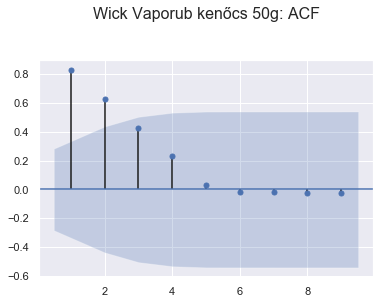

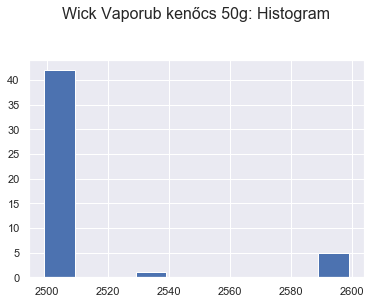

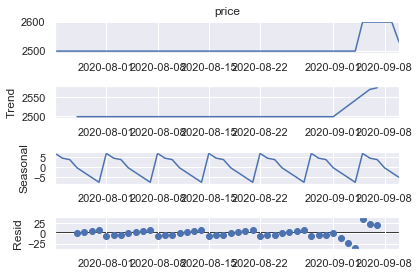

Wick Vaporub kenőcs 50g:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -202.026
Date:                Fri, 12 Feb 2021   AIC                            406.052
Time:                        12:59:33   BIC                            407.902
Sample:                             0   HQIC                           406.748
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       317.0432     18.407     17.225      0.000     280.967     353.119
Ljung-Box (Q):                       12.37   Jarque-Bera (JB):              1077.61
Prob(Q):              

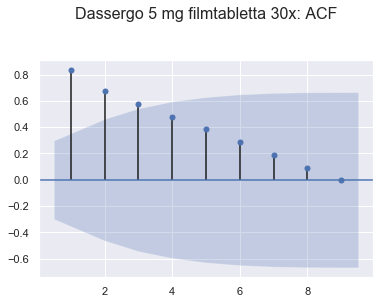

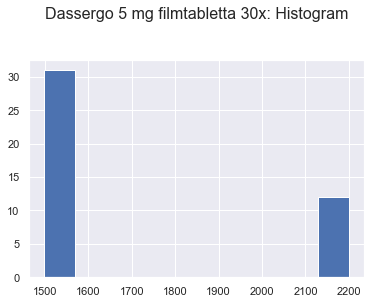

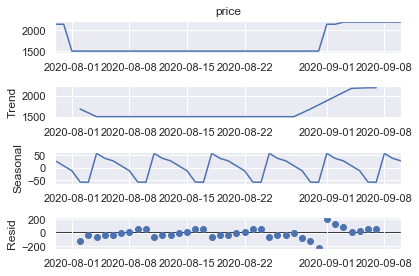

Dassergo 5 mg filmtabletta 30x:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   43
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -267.755
Date:                Fri, 12 Feb 2021   AIC                            537.511
Time:                        12:59:38   BIC                            539.248
Sample:                             0   HQIC                           538.148
                                 - 43                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.017e+04   1396.015     14.451      0.000    1.74e+04    2.29e+04
Ljung-Box (Q):                       42.12   Jarque-Bera (JB):               559.47
Prob(Q):       

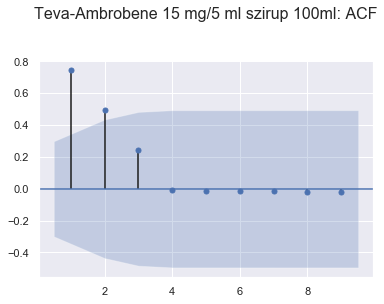

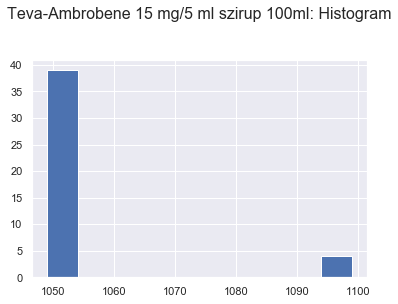

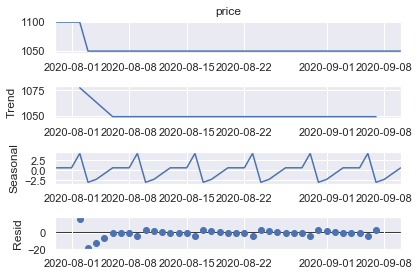

Teva-Ambrobene 15 mg/5 ml szirup 100ml:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   43
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -151.273
Date:                Fri, 12 Feb 2021   AIC                            308.547
Time:                        12:59:44   BIC                            313.830
Sample:                             0   HQIC                           310.495
                                 - 43                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    262.2345    162.759      1.611      0.107     -56.768     581.237
ar.L1          0.7517      0.151      4.985      0.000       0.456       1.047
sigma2      

In [54]:
#Walk through the list of non_stationary product data
auto_arima_orders=[]
if len(benu_daily_ts_not_non_stationary)>0:
    for i in range(len(benu_daily_ts_not_non_stationary)):
        benu_daily_ts_temp=benu_daily_ts[benu_daily_ts['product_name']==benu_daily_ts_not_non_stationary[i]].sort_index()
        array_len_temp=len(benu_daily_ts[benu_daily_ts['product_name']==benu_daily_ts_not_non_stationary[i]].sort_index())

        benu_daily_ts_temp.reset_index(drop=False, inplace=True)
        benu_daily_ts_temp.drop_duplicates(subset ="date",keep = False, inplace = True) 
        #print(type(benu_daily_ts_temp.date.iloc[0]))

        benu_daily_ts_temp_merged=pd.merge(benu_daily_ts_temp,covid_data_exog, on='date', how='inner')
        benu_daily_ts_temp_merged.set_index('date', inplace=True)

    # #     print(benu_daily_ts_temp_merged_merged)
    # #     print(np.array(benu_daily_ts_temp_merged_merged[['product_name']])[0][0])
    # #     print(benu_daily_ts_temp_merged_merged[['death_stat']])

        #Set freq
        benu_daily_ts_temp_merged=benu_daily_ts_temp_merged.asfreq('d')
        
        #print(benu_daily_ts_temp_merged[['product_name']].iloc[0][0])


    #     #Try to diff
    #     y=benu_daily_ts_temp_merged.price
    #     print(ndiffs(y, test='adf'))


        #Plot ACF
        #40lags is the best practice but I use the number of lags applied by KPSS
        sgt.plot_acf(benu_daily_ts_temp_merged.price, lags=(benu_daily_ts_stationarity['KPSS_lags_used'].iloc[0].astype(int)), zero=False) 
        plt.title((str(benu_daily_ts_temp_merged[['product_name']].iloc[0][0])+": "+"ACF"+"\n" + "\n" ), size=16)
        plt.show()

    # #     PACF 
    # #     sgt.plot_pacf(benu_daily_ts_temp_merged.price, lags=benu_daily_ts_stationarity['KPSS_lags_used'].iloc[0].astype(int), zero=False, method=('ols'))
    # #     plt.title((": "+"PACF Price"), size=24)
    # #     plt.show()

        #Histogram
        benu_daily_ts_temp_merged.price.hist()
        plt.title((str(benu_daily_ts_temp_merged[['product_name']].iloc[0][0])+": "+"Histogram"+"\n" + "\n" ), size=16)
        plt.show()

        #Seasonality
        s_dec_additive=seasonal_decompose(benu_daily_ts_temp_merged.price, model="additive")
        s_dec_additive.plot()
        plt.show()

    #     #simple test of stationarity, but it works only if there is daily price change as I understood(examines shape[1] compary to shape[0])
    #     #this needed to be installed pip install stationarizer
    #     #benu_daily_ts_temp_merged_statz = simple_auto_stationarize(benu_daily_ts_temp_merged.price)
    #     #print(benu_daily_ts_temp_merged_statz)

        #build model_auto_arima
        model_auto=auto_arima(benu_daily_ts_temp_merged.price)
        #print(str(model_auto)+ "\n" + "\n")
        print((str(benu_daily_ts_temp_merged[['product_name']].iloc[0][0])+": "+str(model_auto.summary())+"\n" + "\n"))

    # #     #build model_auto_arima with more arguments - the summary does not load 
    # #     model_auto_args=auto_arima(benu_daily_ts_temp_merged.price, exog=benu_daily_ts_temp_merged[['death_stat']], m=5, max_order=None, max_p=7, max_q=7,max_d=2, max_P=4, max_Q=4, max_D=2, maxiter=50, alpha=0.05, n_jobs=-1, trend='ct', information_criterion='oob',out_of_sample_size=int(len(benu_daily_ts_temp_merged.price)*0.2))
    # #     print(str(model_auto_args)+ "\n" + "\n")
    # #     print(": "+str(model_auto_args.summary())+"\n" + "\n")

        #Get order for model from auto_arima
        order=str(model_auto.summary()).split("Model:")[1].split("Log")[0].split("(")[1].replace(")","").strip().split(",")
        order = [int(i) for i in order] 
        auto_arima_orders.append(order)
        #print(order)

    #   build model_sarimax (ideally exog data should come from the correlation analisys this will be implemented in a)
        if str(model_auto.summary()).split("Model:")[1].split("Log")[0].split("(")[0].strip()=='SARIMAX':
            model_sarimax=SARIMAX(benu_daily_ts_temp_merged.price, exog=benu_daily_ts_temp_merged[['death_stat']], order=(order))
            result_sarimax=model_sarimax.fit()
            print(str(benu_daily_ts_temp_merged[['product_name']].iloc[0][0])+": "+str(result_sarimax.summary()))


In [55]:
auto_arima_orders

[[0, 1, 0], [0, 1, 0], [1, 0, 0]]

In [56]:
print(str(auto_arima_orders[0][0])+" "+str(auto_arima_orders[0][1])+" "+str(auto_arima_orders[0][2]))
print(str(auto_arima_orders[1][0])+" "+str(auto_arima_orders[1][1])+" "+str(auto_arima_orders[1][2]))
print(str(auto_arima_orders[2][0])+" "+str(auto_arima_orders[2][1])+" "+str(auto_arima_orders[2][2]))


0 1 0
0 1 0
1 0 0


In [57]:
len(benu_daily_ts_not_non_stationary)

3

# Loop through and analyze only the stationary data / part#2

In [58]:
#LLR(Log Likely Hood) Test 
def LLR_test(mod_1,mod_2, DF=1):
    L1=mod_1.fit().llf
    L2=mod_2.fit().llf
    LR=(2*(L2-L1))
    p=chi2.sf(LR,DF).round(3)
    return p

In [ ]:
#Walk through the list of non_stationary product data
#Ideally by each modell I should check the p value of the current model and evaluate if number of lags can be increased or I should stick with the current model

#Create dataframe to save model evaluation at the end
model_results=pd.DataFrame(columns=['product_name','model','data','mean_squared_error','mean_10%','is_fitting'])
list_of_product_name_lr=[]
list_of_model_lr=[]
list_of_data_lr=[]
list_of_msr_lr=[]
list_of_mean_10_lr=[]
list_of_fitting_lr=[]

#Walking through the dataframe, build the models and run prediction in loop 
for j in range(len(benu_daily_ts_not_non_stationary)):   
    benu_daily_ts_temp=benu_daily_ts[benu_daily_ts['product_name']==benu_daily_ts_not_non_stationary[j]].sort_index()
    array_len_temp=len(benu_daily_ts[benu_daily_ts['product_name']==benu_daily_ts_not_non_stationary[j]].sort_index())
    
    benu_daily_ts_temp.reset_index(drop=False, inplace=True)
    #print(benu_daily_ts_temp_merged)
    covid_data_exog_tempt=covid_data_exog[['date','death_stat']]
    #print(covid_data_exog_tempt)
    
    benu_daily_ts_temp_merged=pd.merge(benu_daily_ts_temp,covid_data_exog_tempt, on='date', how='inner')
    benu_daily_ts_temp_merged.set_index('date', inplace=True)
    #print(benu_daily_ts_temp_merged.product_name.values)
    
    #Set freq
    benu_daily_ts_temp_merged=benu_daily_ts_temp_merged.asfreq('d')
    benu_daily_ts_temp_merged#Try to diff
    
    product_name=benu_daily_ts_temp_merged.product_name.iloc[j]
    
    #Normalizing Price
    benchmark=benu_daily_ts_temp_merged.price.iloc[0]
    benu_daily_ts_temp_merged['norm_price']=benu_daily_ts_temp_merged.price.div(benchmark).mul(100)
    
    #Lags to use
    lags_to_use=(int(np.array(benu_daily_ts_stationarity[benu_daily_ts_stationarity['product_names']==benu_daily_ts_not_non_stationary[j]]['KPSS_lags_used'])[0]))
    #print(lags_to_use)
    
    ############
    #TEST MODELS
    ############

    #Build AR model in loop based on KPSS number of lags
    model_ar_temp_name_list=[]
    model_ar_temp_p_value_list=[]
    model_ar_temp_AIC_list=[]
    
    for i in range(1,lags_to_use):
        model_ar_temp=ARMA(benu_daily_ts_temp_merged.price, order=(i,0))
        results_ar_temp=model_ar_temp.fit()
        #print(results_ar_temp.summary())
        
        model_ar_temp_name=str(results_ar_temp.summary()).split("Model:")[1].split("Log Likelihood")[0]
        model_ar_temp_name_list.append(model_ar_temp_name)
        #print(model_ar_temp_name)
        
        model_name_split="ar.L"+str(i)+".price"
        #print(model_name_split)
        
        p_value_temp=(str(results_ar_temp.summary()).split(str(model_name_split))[1].strip().split("Roots")[0].strip().replace("       ",";").strip().replace("      ",";").strip().replace("     ",";").strip().replace("    ",";").strip().replace("   ",";").strip().replace("  ",";").strip().replace(" ",";").strip().replace(";;",";").strip().split(";")[3])
        #print(p_value_temp)
        
        #p value can be NaN
        if p_value_temp!='nan':
            model_ar_temp_p_value_list.append(p_value_temp)
        else:model_ar_temp_p_value_list.append(np.nan)
        #print(model_ar_temp_p_value_list)
             
        model_ar_temp_AIC=float(format(float(str(results_ar_temp.summary()).split("AIC")[1].split("Time:")[0].strip()),'.4f'))
        model_ar_temp_AIC_list.append(model_ar_temp_AIC)
        #print(model_ar_temp_AIC)
        
    results_ar_df=pd.DataFrame(columns=['model_ar_name','p_value','AIC'])
    results_ar_df['model_ar_name']=model_ar_temp_name_list
    results_ar_df['p_value']=model_ar_temp_p_value_list
    results_ar_df['AIC']=model_ar_temp_AIC_list
    results_ar_df=results_ar_df.sort_values(by=['p_value','AIC'],ascending=True)
    #print(results_ar_df)
    
    #split the best model setup
    #print(int(results_ar_df.iloc[0][0].split("ARMA")[1].split(",")[0].replace("(","")))
    ar_lags=int(results_ar_df.iloc[0][0].split("ARMA")[1].split(",")[0].replace("(",""))
    #print(ar_lags)
    
    #Run the best AR model
    model_ar_1=ARMA(benu_daily_ts_temp_merged.price, order=(ar_lags,0))
    results_ar_1=model_ar_1.fit()
    #print(str(product_name)+str(results_ar_1.summary())+"\n"+"\n")

################################

    #Build MA model in loop based on KPSS number of lags
    model_ma_temp_name_list=[]
    model_ma_temp_p_value_list=[]
    model_ma_temp_AIC_list=[]
    
    for i in range(1,lags_to_use):
        model_ma_temp=ARMA(benu_daily_ts_temp_merged.price[1:], order=(0,i))
        results_ma_temp=model_ma_temp.fit()
        #print(results_ma_temp.summary())
        
        model_ma_temp_name=str(results_ma_temp.summary()).split("Model:")[1].split("Log Likelihood")[0]
        model_ma_temp_name_list.append(model_ma_temp_name)
        #print(model_ma_temp_name)
        
        model_name_split="ma.L"+str(i)+".price"
        #print(model_name_split)
        
        p_value_temp=(str(results_ma_temp.summary()).split(str(model_name_split))[1].strip().split("Roots")[0].strip().replace("       ",";").strip().replace("      ",";").strip().replace("     ",";").strip().replace("    ",";").strip().replace("   ",";").strip().replace("  ",";").strip().replace(" ",";").strip().replace(";;",";").strip().split(";")[3])
        #print(p_value_temp)
        
        #p value can be NaN
        if p_value_temp!='nan':
            model_ma_temp_p_value_list.append(float(p_value_temp))
        else:model_ma_temp_p_value_list.append(np.nan)
    
        
        model_ma_temp_AIC=float(format(float(str(results_ma_temp.summary()).split("AIC")[1].split("Time:")[0].strip()),'.4f'))
        model_ma_temp_AIC_list.append(model_ma_temp_AIC)
        
    #print(str(len(model_ma_temp_AIC_list))+";"+str(len(model_ma_temp_p_value_list))) 
      
    results_ma_df=pd.DataFrame(columns=['model_ma_name','p_value','AIC'])
    results_ma_df['model_ma_name']=model_ma_temp_name_list
    results_ma_df['p_value']=model_ma_temp_p_value_list
    results_ma_df['AIC']=model_ma_temp_AIC_list
    results_ma_df=results_ma_df.sort_values(by=['p_value','AIC'],ascending=True)
    #print(results_ma_df)
    
    #split the best model setup
    #print(int(results_ar_df.iloc[0][0].split("ARMA")[1].split(",")[1].replace(")","")))
    ma_lags=int(results_ma_df.iloc[0][0].split("ARMA")[1].split(",")[1].replace(")",""))
    #print(ma_lags)
    
    #Run the best MA model
    model_prices_ma_1=ARMA(benu_daily_ts_temp_merged.price[1:],order=(0,ma_lags))
    results_prices_ma_1=model_prices_ma_1.fit()
    #print(str(product_name)+": "+str(results_prices_ma_1.summary())+"\n"+"\n")
    
#######################   

    #Build ARMA model
    model_price_ar_1_ma_1=ARMA(benu_daily_ts_temp_merged.price[1:],order=(ar_lags,ma_lags))
    result_price_ar_1_ma_1=model_price_ar_1_ma_1.fit()
    #print(str(product_name)+": "+str(result_price_ar_1_ma_1.summary())+"\n"+"\n")
    
#     #LLR test
#     model_price_ar_1=ARMA(benu_daily_ts_temp_merged.price, order=(ar_lags,0))
#     model_price_ma_1=ARMA(benu_daily_ts_temp_merged.price[1:], order=(0,ma_lags))
    
#     #ARMA vs AR - p value
#     print(str(LLR_test(model_price_ar_1, model_price_ar_1_ma_1)))
    
#########################


    #Build ARIMA model
#     print(auto_arima_orders[j][0],auto_arima_orders[j][1],auto_arima_orders[j][2])
#     #Build as per auto ARIMA
    model_price_ar_1_i_1_ma_1=ARIMA(benu_daily_ts_temp_merged.price,order=(auto_arima_orders[j][0],auto_arima_orders[j][1],auto_arima_orders[j][2]))
    result_price_ar_1_i_1_ma_1=model_price_ar_1_i_1_ma_1.fit()
#     print(str(product_name)+": "+str(result_price_ar_1_i_1_ma_1.summary())+"\n"+"\n")
    
#     #Build as per best AR and best MA
#     #print(str(ar_lags)+str(ma_lags))
#     model_price_ar_1_i_1_ma_1_v2=ARIMA(benu_daily_ts_temp_merged.price,order=(ar_lags,0,ma_lags))
#     result_price_ar_1_i_1_ma_1_v2=model_price_ar_1_i_1_ma_1_v2.fit()
#     print(str(product_name)+": "+str(result_price_ar_1_i_1_ma_1_v2.summary())+"\n"+"\n")
       
#     print(str(LLR_test(model_price_ar_1_i_1_ma_1, model_price_ar_1_i_1_ma_1_v2)))
#     print(str(LLR_test(model_price_ar_1, model_price_ar_1_i_1_ma_1)))
    
#     #Residuals of ARIMA(1,1,1)
#     #Working with resid does not work, this is a known issue: https://github.com/statsmodels/statsmodels/issues/3504
#     #Returns with "Cannot cast ufunc 'subtract' output from dtype('float64') to dtype('int64') with casting rule" error  
#     # print(result_price_ar_1_i_1_ma_1.resid)
#     benu_daily_ts_temp_merged['res_price_ar_1_i_1_ma_1']=result_price_ar_1_i_1_ma_1.resid
#     #print(benu_daily_ts_temp_merged['res_price_ar_1_i_1_ma_1'])
#     sgt.plot_acf(benu_daily_ts_temp_merged['res_price_ar_1_i_1_ma_1'][1:], zero=False, lags=benu_daily_ts_stationarity['KPSS_lags_used'].iloc[0].astype(int))
#     plt.show()

#     #Check if normalized price changes p value 
#     model_norm_price_ar_1_i_1_ma_1=ARIMA(benu_daily_ts_temp_merged.norm_price,order=(auto_arima_orders[j][0],auto_arima_orders[j][1],auto_arima_orders[j][2]))
#     result_norm_price_ar_1_i_1_ma_1=model_norm_price_ar_1_i_1_ma_1.fit()
    #print(str(product_name)+": "+str(result_norm_price_ar_1_i_1_ma_1.summary())+"\n"+"\n")
       
#     #Comparing Arima with price and Arima with norm price & comparing Arima to AR
#     #Returns with "Model has been fit using trend=c and method=css-mle. These cannot be changed in subsequent calls to `fit`. Instead, use a new instance of ARMA." error message
#     print(str(LLR_test(model_price_ar_1_i_1_ma_1, model_norm_price_ar_1_i_1_ma_1)))
#     print(str(LLR_test(model_price_ar_1, model_norm_price_ar_1_i_1_ma_1)))

      
#     #Build ARIMAX model
    model_ar_1_i_1_ma_1_ds=ARIMA(benu_daily_ts_temp_merged.price, exog=benu_daily_ts_temp_merged[['death_stat']], order=(auto_arima_orders[j][0],auto_arima_orders[j][1],auto_arima_orders[j][2]))
    result_ar_1_i_1_ma_1_ds=model_ar_1_i_1_ma_1_ds.fit()
#     print(str(product_name)+": "+str(result_ar_1_i_1_ma_1_ds.summary())+"\n"+"\n")

#     ############
#     #RUN FORCAST
#     ############
    
    #set start date
    start_date = benu_daily_ts_temp_merged.index[0].strftime("%Y-%m-%d")
    start_date
    #print(start_date)

    #set end date
#     now = datetime.now()
#     end_date = now.strftime("%Y-%m-%d")
#     end_date
    
    #set end date for the analyzed time period
    end_date=pd.to_datetime('2020-09-10')
    
#     #Splitting the data to training and test sets - this is not required since i split the data based on date..
#     size=int(len(benu_daily_ts_temp_merged)*0.8)
#     benu_daily_ts_temp_merged_train=benu_daily_ts_temp_merged.iloc[:size]
#     benu_daily_ts_temp_merged_test=benu_daily_ts_temp_merged.iloc[size:]
    
#      #Fitting a model - prediction AR
    benu_daily_ts_temp_merged_pred_ar_1 = results_ar_1.predict(start = start_date, end = end_date)
             
    start_date = benu_daily_ts_temp_merged.index[0].strftime("%Y-%m-%d") 
    benu_daily_ts_temp_merged_pred_ar_1[start_date:end_date].plot(figsize=(20,5),color="red")
    benu_daily_ts_temp_merged.price[start_date:end_date].plot(color="blue")
    plt.title((str(product_name)+": "+"predictions AR vs actual data"), size=24)
    plt.show()
    
    #Evaluating the modell
    print('Mean Absolute Error:', metrics.mean_absolute_error(benu_daily_ts_temp_merged.price, benu_daily_ts_temp_merged_pred_ar_1))
    print('Mean Squared Error:', metrics.mean_squared_error(benu_daily_ts_temp_merged.price, benu_daily_ts_temp_merged_pred_ar_1))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(benu_daily_ts_temp_merged.price, benu_daily_ts_temp_merged_pred_ar_1)))

    if ((metrics.mean_squared_error(benu_daily_ts_temp_merged.price, benu_daily_ts_temp_merged_pred_ar_1)/benu_daily_ts_temp_merged.price.mean())*100)<10:
        print(str(metrics.mean_squared_error(benu_daily_ts_temp_merged.price, benu_daily_ts_temp_merged_pred_ar_1))+"is lower than 10% of mean price:"+str(benu_daily_ts_temp_merged.price.mean()*0.1))
        list_of_fitting_lr.append('yes')
    else: print(str(metrics.mean_squared_error(benu_daily_ts_temp_merged.price, benu_daily_ts_temp_merged_pred_ar_1))+"is higher than 10% of mean price:"+str(benu_daily_ts_temp_merged.price.mean()*0.1));list_of_fitting_lr.append('no')
    #mean is less than 10% of the mean price so the prediction is good one
    
    list_of_product_name_lr.append(str(product_name))
    list_of_model_lr.append('AR')
    list_of_data_lr.append('date')
    list_of_msr_lr.append((metrics.mean_squared_error(benu_daily_ts_temp_merged.price, benu_daily_ts_temp_merged_pred_ar_1)))
    list_of_mean_10_lr.append(benu_daily_ts_temp_merged.price.mean()*0.1)
####################

#     #Fitting model - prediction MA
    benu_daily_ts_temp_merged_pred_ma_1 = results_prices_ma_1.predict(start = benu_daily_ts_temp_merged.index[1].strftime("%Y-%m-%d"), end = end_date) 
    
    start_date = benu_daily_ts_temp_merged.index[1].strftime("%Y-%m-%d")
    benu_daily_ts_temp_merged_pred_ma_1[start_date:end_date].plot(figsize=(20,5),color="red")
    benu_daily_ts_temp_merged.price[start_date:end_date].plot(color="blue")
    plt.title((str(product_name)+": "+"predictions MA vs actual data"), size=24)
    plt.show()

    #Evaluating the modell
#     print(len(benu_daily_ts_temp_merged_pred_ma_1))
#     print(len(benu_daily_ts_temp_merged.price[1:]))
#     print(str(benu_daily_ts_temp_merged.price)+";"+str(benu_daily_ts_temp_merged_pred_ma_1))

    print('Mean Absolute Error:', metrics.mean_absolute_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ma_1))
    print('Mean Squared Error:', metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ma_1))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ma_1)))

    if ((metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ma_1)/benu_daily_ts_temp_merged.price[1:].mean())*100)<10:
        print(str(metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ma_1))+"is lower than 10% of mean price:"+str(benu_daily_ts_temp_merged.price[1:].mean()*0.1))
        list_of_fitting_lr.append('yes')
    else: print(str(metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ma_1))+"is higher than 10% of mean price:"+str(benu_daily_ts_temp_merged.price[1:].mean()*0.1));list_of_fitting_lr.append('no')
    #mean is less than 10% of the mean price so the prediction is good one
    
    list_of_product_name_lr.append(str(product_name))
    list_of_model_lr.append('MA')
    list_of_data_lr.append('date')
    list_of_msr_lr.append(metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ma_1))
    list_of_mean_10_lr.append(benu_daily_ts_temp_merged.price[1:].mean()*0.1)

# ####################

#     #Fitting model - prediction ARMA
    benu_daily_ts_temp_merged_pred_arma_1=result_price_ar_1_ma_1.predict(start = benu_daily_ts_temp_merged.index[1].strftime("%Y-%m-%d"), end = end_date) 
    
    start_date = benu_daily_ts_temp_merged.index[1].strftime("%Y-%m-%d")
    benu_daily_ts_temp_merged_pred_arma_1[start_date:end_date].plot(figsize=(20,5),color="red")
    benu_daily_ts_temp_merged.price[start_date:end_date].plot(color="blue")
    plt.title((str(product_name)+": "+"predictions ARMA vs actual data"), size=24)
    plt.show()

    #Evaluating the modell
    print('Mean Absolute Error:', metrics.mean_absolute_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_arma_1))
    print('Mean Squared Error:', metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_arma_1))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_arma_1)))

    if ((metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_arma_1)/benu_daily_ts_temp_merged.price[1:].mean())*100)<10:
        print(str(metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_arma_1))+"is lower than 10% of mean price:"+str(benu_daily_ts_temp_merged.price[1:].mean()*0.1))
        list_of_fitting_lr.append('yes')
    else: print(str(metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_arma_1))+"is higher than 10% of mean price:"+str(benu_daily_ts_temp_merged.price[1:].mean()*0.1));list_of_fitting_lr.append('no')
    #mean is less than 10% of the mean price so the prediction is good one
    
    list_of_product_name_lr.append(str(product_name))
    list_of_model_lr.append('ARMA')
    list_of_data_lr.append('date')
    list_of_msr_lr.append(metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_arma_1))
    list_of_mean_10_lr.append(benu_daily_ts_temp_merged.price[1:].mean()*0.1)

# ###################

# #     #Fitting model - prediction ARIMA
    benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1=result_price_ar_1_i_1_ma_1.predict(start = benu_daily_ts_temp_merged.index[1].strftime("%Y-%m-%d"), end = end_date) 
    start_date = benu_daily_ts_temp_merged.index[1].strftime("%Y-%m-%d")
    benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1[start_date:end_date].plot(figsize=(20,5),color="red")
    benu_daily_ts_temp_merged.price[start_date:end_date].plot(color="blue")
    plt.title((str(product_name)+": "+"predictions ARIMA vs actual data"), size=24)
    plt.show()

    #Evaluating the modell
    print('Mean Absolute Error:', metrics.mean_absolute_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1))
    print('Mean Squared Error:', metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1)))

    if ((metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1)/benu_daily_ts_temp_merged.price[1:].mean())*100)<10:
        print(str(metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1))+"is lower than 10% of mean price:"+str(benu_daily_ts_temp_merged.price[1:].mean()*0.1))
        list_of_fitting_lr.append('yes')
    else: print(str(metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1))+"is higher than 10% of mean price:"+str(benu_daily_ts_temp_merged.price[1:].mean()*0.1));list_of_fitting_lr.append('no')
    #mean is less than 10% of the mean price so the prediction is good one
    
    list_of_product_name_lr.append(str(product_name))
    list_of_model_lr.append('ARIMA')
    list_of_data_lr.append('date')
    list_of_msr_lr.append(metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1))
    list_of_mean_10_lr.append(benu_daily_ts_temp_merged.price[1:].mean()*0.1)
    
#####################

    #Fitting model - prediction ARIMAX - returns with error due to the NaN values
    benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1_ds=result_ar_1_i_1_ma_1_ds.predict(start = benu_daily_ts_temp_merged.index[1].strftime("%Y-%m-%d"), end = end_date, exog=benu_daily_ts_temp_merged[['death_stat']]) 
    start_date = benu_daily_ts_temp_merged.index[1].strftime("%Y-%m-%d")
    benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1_ds[start_date:end_date].plot(figsize=(20,5),color="red")
    benu_daily_ts_temp_merged.price[start_date:end_date].plot(color="blue")
    plt.title((str(product_name)+": "+"predictions ARIMAX vs actual data"), size=24)
    plt.show()   

    #Evaluating the modell
    print('Mean Absolute Error:', metrics.mean_absolute_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1_ds))
    print('Mean Squared Error:', metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1_ds))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1_ds)))

    if ((metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1_ds)/benu_daily_ts_temp_merged.price[1:].mean())*100)<10:
        print(str(metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1_ds))+"is lower than 10% of mean price:"+str(benu_daily_ts_temp_merged.price[1:].mean()*0.1))
        list_of_fitting_lr.append('yes')
    else: print(str(metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1_ds))+"is higher than 10% of mean price:"+str(benu_daily_ts_temp_merged.price[1:].mean()*0.1));list_of_fitting_lr.append('no')
    #mean is less than 10% of the mean price so the prediction is good one
    
    list_of_product_name_lr.append(str(product_name))
    list_of_model_lr.append('ARIMAX')
    list_of_data_lr.append('date'+","+'covid_death_stat')
    list_of_msr_lr.append(metrics.mean_squared_error(benu_daily_ts_temp_merged.price[1:], benu_daily_ts_temp_merged_pred_ar_1_i_1_ma_1_ds))
    list_of_mean_10_lr.append(benu_daily_ts_temp_merged.price[1:].mean()*0.1)


model_results['product_name']=list_of_product_name_lr
model_results['model']=list_of_model_lr     
model_results['data']=list_of_data_lr
model_results['mean_squared_error']=list_of_msr_lr
model_results['mean_10%']=list_of_mean_10_lr
model_results['is_fitting']=list_of_fitting_lr
model_results

#create excel writer object
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y")
writer = pd.ExcelWriter(str(dt_string)+'timeseries_summary_table_r05'+'.xlsx')
# write dataframe to excel
model_results.to_excel(writer)
# save the excel
writer.save()
print('DataFrame is written successfully to Excel File.')
 